In [285]:
import os
import fnmatch
import itertools
from datetime import datetime
from pathlib import Path

import geowombat as gw
# from tsplanet import download_data

import geopandas as gpd
import numpy as np
import numba as nb
import sklearn_crfsuite
from affine import Affine
from tqdm import tqdm
import matplotlib.pyplot as plt

## Functions

In [3]:
# str_to_int_dict = dict(n=0, a=1, g=1, t=1, u=1, b=1, w=2, c=3, s=4, h=5)
# str_to_int_dict = dict(n=0, a=1, g=2, t=3, u=4, b=5, w=6, c=7, s=8, h=9)
str_to_int_dict = dict(n=0, l=1, u=2, w=3, c=4, s=5, h=6)

int_to_str_dict = dict()
for k, v in str_to_int_dict.items():
    int_to_str_dict[v] = k

In [4]:
def str_to_int(row):
    str_values = row['class'].split(',')
    return ','.join([str(str_to_int_dict[sv]) for sv in str_values])

In [134]:
def label_decoder(label):
    return int_to_str_dict[label]


def get_sample_xy(sample):
    
    """
    Converts a DataFrame sample to a CRF feature
    """
    
    date_diff = sample.date2.to_pydatetime().toordinal() - sample.date1.to_pydatetime().toordinal()
    
    b1_diff = int(sample.b1) - int(sample.b1_1)
    b2_diff = int(sample.b2) - int(sample.b2_1)
    b3_diff = int(sample.b3) - int(sample.b3_1)
    b4_diff = int(sample.b4) - int(sample.b4_1)
    b5_diff = int(sample.b5) - int(sample.b5_1)
    b6_diff = int(sample.b6) - int(sample.b6_1)
    
    b1_diff_2 = int(sample.b1_2) - int(sample.b1)
    b2_diff_2 = int(sample.b2_2) - int(sample.b2)
    b3_diff_2 = int(sample.b3_2) - int(sample.b3)
    b4_diff_2 = int(sample.b4_2) - int(sample.b4)
    b5_diff_2 = int(sample.b5_2) - int(sample.b5)
    b6_diff_2 = int(sample.b6_2) - int(sample.b6)
    
    diff1 = ['b1-diff1', 'b2-diff1', 'b3-diff1', 'b4-diff1', 'b5-diff1', 'b6-diff1']
    diff2 = ['b1-diff2', 'b2-diff2', 'b3-diff2', 'b4-diff2', 'b5-diff2', 'b6-diff2']
    
    slab = band_names + ['date-diff'] + diff1 + diff2
    
    diff1_values = [b1_diff, b2_diff, b3_diff, b4_diff, b5_diff, b6_diff]
    diff2_values = [b1_diff_2, b2_diff_2, b3_diff_2, b4_diff_2, b5_diff_2, b6_diff_2]
    
    sfea = np.array(sample[band_names].values.tolist() + [date_diff] + diff1_values + diff2_values, dtype='float64')

    return dict(zip(slab, sfea)), label_decoder(int(sample.poly))


def get_array_xy(sample):
    return dict(zip(band_names, sample))

    
def samples_to_features(dfs):
    
    """
    sample = [[{t1}, {t2}, ..., {tn}], ..., [...]]
    """
    
    return [list(zip(*df.apply(get_sample_xy, axis=1))) for df in dfs]


@nb.jit
def sample_to_dict(array_sample):

#     diff1 = ['b1-diff1', 'b2-diff1', 'b3-diff1', 'b4-diff1', 'b5-diff1', 'b6-diff1']
#     diff2 = ['b1-diff2', 'b2-diff2', 'b3-diff2', 'b4-diff2', 'b5-diff2', 'b6-diff2']
    
#     slab = band_names + ['date-diff'] + diff1 + diff2
    
    slab = ['b'+str(r) for r in range(1, len(array_sample)+1)]

    return dict(zip(slab, np.float64(array_sample)))    


@nb.jit
def array_to_dict(*args):
    
    """
    Converts array sample to a CRF features
    """
    
    return [sample_to_dict(sample) for sample in args]

## Extract data

In [301]:
rpath = Path('/media/jcgr/data/imagery/google/p225r083/brdf')
vpath = Path('/media/jcgr/data/imagery/google/training/p225r83.shp')

df = gpd.read_file(vpath.as_posix())

df.head()

,id,label,image,geometry
0,None,s,LC08_L1TP_225083_20180909_20180912_01_T1,"POLYGON ((423843.934 -3620112.050, 423843.934 ..."
1,None,w,LC08_L1TP_225083_20180909_20180912_01_T1,"POLYGON ((386814.210 -3594589.188, 386814.210 ..."
2,None,s,LC08_L1TP_225083_20180909_20180912_01_T1,"POLYGON ((421225.313 -3618877.914, 421225.313 ..."
3,None,l,LC08_L1TP_225083_20180909_20180912_01_T1,"POLYGON ((424109.777 -3616418.758, 424109.777 ..."
4,None,s,LC08_L1TP_225083_20180909_20180912_01_T1,"POLYGON ((419372.737 -3615611.549, 419372.737 ..."


In [302]:
minrow = 1e9
mincol = 1e9

X_data = list()
y_data = list()

for row in tqdm(df.itertuples(index=True, name='Pandas'), total=df.shape[0]):
    
    with gw.open(rpath.joinpath(row.image + '.tif').as_posix(), chunks=64) as ds:
        
        clip = gw.clip(ds, df, query="index == {:d}".format(row.Index), mask_data=False)
        subset = clip.data.compute()
        minrow = min(subset.shape[1], minrow)
        mincol = min(subset.shape[2], mincol)
        X_data.append(subset)
        y_data.append(row.label)
    
X_data = np.array([d[:, :minrow, :mincol] for d in X_data], dtype='float64')

100%|██████████| 39/39 [00:04<00:00,  8.96it/s]


### Generate N randomly sorted arrays

In [287]:
# def stack_features(barray, nrows, ncols):
    
#     z = np.zeros((nrows, ncols), dtype='uint64')
    
#     return np.concatenate(barray,
#                           nir1_diff_array1[np.newaxis, :, :])

In [303]:
ntime, nbands, nrows, ncols = X_data.shape
features = list()

# Augment the data
X = list()
y = list()
for i in range(0, ntime*ntime):
    
    idx = np.random.choice(range(0, ntime), size=ntime, replace=False)
    X.append(X_data[idx])
    y.append(np.array(y_data)[idx].tolist())
    
X = np.vstack(X)
X = [dlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for dlayer in X]
X = [array_to_dict(*[X[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [306]:
len(X[0])

39

## Model

In [307]:
# Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
model = sklearn_crfsuite.CRF(algorithm='lbfgs', 
                             c1=0.001,
                             c2=0.001,
                             max_iterations=1000,
                             num_memories=10,
                             epsilon=0.0001,
                             delta=0.0001,
                             period=10,
                             linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
                             max_linesearch=20,
                             all_possible_states=True,
                             all_possible_transitions=True,
                             verbose=False)

In [308]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.001, c2=0.001, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=0.0001, epsilon=0.0001,
    error_sensitive=None, gamma=None, keep_tempfiles=None,
    linesearch='StrongBacktracking', max_iterations=1000, max_linesearch=20,
    min_freq=None, model_filename=None, num_memories=10, pa_type=None,
    period=10, trainer_cls=None, variance=None, verbose=False)

In [309]:
X_data.shape

(39, 4, 8, 9)

In [310]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in X_data]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [311]:
def pred_to_labels(model_pred):
    
    # samples x time x n classes
    return np.array([[[ps['l'], ps['u'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] for p in model_pred], dtype='float64')

In [312]:
pred = pred_to_labels(model.predict_marginals(features))
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [313]:
pred.shape

(39, 6, 8, 9)

In [314]:
y_data

['s',
 'w',
 's',
 'l',
 's',
 'u',
 'w',
 'c',
 'c',
 'c',
 's',
 's',
 's',
 'u',
 'w',
 'u',
 'u',
 'l',
 'h',
 'c',
 'h',
 'l',
 'u',
 'h',
 's',
 's',
 's',
 'c',
 'h',
 'c',
 'c',
 'c',
 'h',
 's',
 'h',
 'h',
 's',
 's',
 's']

In [324]:
time_index = 34
classes = ['l', 'u', 'w', 'c', 's', 'h']

print('True:', y_data[time_index])
print('')

for j in range(0, len(classes)):
    print('Predicted {}:'.format(classes[j]), pred[time_index][j].max())

True: h

Predicted l: 0.08985458004061297
Predicted u: 0.1255834563393863
Predicted w: 0.08009248338181693
Predicted c: 0.2128876801274371
Predicted s: 0.3367848497301423
Predicted h: 0.2140522422021149


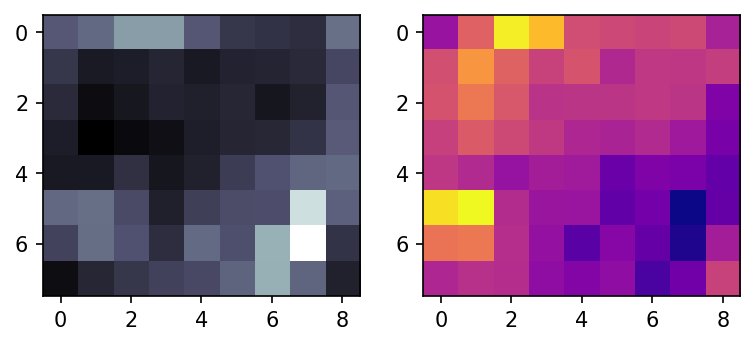

In [318]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150)

# Time n, mean over bands
ax1.imshow(X_data[0].mean(axis=0), cmap='bone')

# Time n, predicted probabilities for class k
ax2.imshow(pred[0][1], cmap='plasma')

plt.show()

## Download PlanetScope data

In [198]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [7]:
def setup_names(grid, filenames):
    
    rpath_dict = {'t55jel': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't56jkt': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't55kcu': '/scratch/rsc8/hardtkel/rapidfires/LW/{}'.format(grid),
                  'l8': '/media/jcgr/data/imagery/google/p225r083/brdf'}
    
    NameInfo = namedtuple('NameInfo', 'rasters vector, time_names')
    
    #vector_dir = Path('/scratch/rsc4/graesser/temp/s2/training')
    vector_dir = Path('/media/jcgr/data/imagery/google/training')
    
    image_dir = Path(rpath_dict[grid])
    
    filename_dict = dict()
    for fn in filenames:
        filename_dict[fn.split('_')[2]] = fn

    sorted_names = list(zip(*sorted(filename_dict.items())))
    
    filenames = list(sorted_names[1])
    
    time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]
    
    rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
    vector = vector_dir.joinpath('{}.shp'.format(grid)).as_posix()
    
    return NameInfo(rasters=rasters, vector=vector, time_names=time_names)

In [9]:
filenames = fnmatch.filter(os.listdir(image_dir.as_posix()), '*.tif')

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[3]] = fn

In [10]:
sorted_names = list(zip(*sorted(filename_dict.items())))

In [11]:
filenames = list(sorted_names[1])

In [12]:
time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

In [13]:
rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
vector = vector_dir.joinpath('p225r83.shp').as_posix()

### Plot the intersection

In [207]:
# with gw.config.update(ref_image=rasters[0], 
#                       ref_res=(10, 10), 
#                       sensor='planetscope'):
    
#     with gw.open(rasters,
#                  time_names=time_names,
#                  how='intersection',
#                  chunks=512) as ds:
        
#         dss = ds.mean(dim='time')
#         dss.attrs = ds.attrs
#         print(ds)
        
#         #dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

### Extract samples

#### Split samples

In [208]:
df = gpd.read_file(vector)

df['class_len'] = df['class'].str.len()
df['int_class'] = df.apply(str_to_int, axis=1)
out = df['int_class'].str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

In [209]:
df_list[1]

,id,class,geometry,class_len,int_class
0,3,"a,c,c,c,c,c,c,c,a,s,c,c,h,a,a,a,a,a","POLYGON ((307838.814 -3622477.261, 307832.864 ...",35,"1,3,3,3,3,3,3,3,1,4,3,3,5,1,1,1,1,1"
1,3,"u,c,c,c,c,c,c,c,u,c,c,c,u,u,u,u,u,u","POLYGON ((323004.578 -3618411.783, 323004.578 ...",35,"1,3,3,3,3,3,3,3,1,3,3,3,1,1,1,1,1,1"
2,3,"w,c,c,c,c,c,c,c,w,w,h,w,c,c,w,c,c,w","POLYGON ((369694.535 -3678582.378, 369694.535 ...",35,"2,3,3,3,3,3,3,3,2,2,5,2,3,3,2,3,3,2"
3,3,"a,c,c,c,c,c,c,c,a,s,c,c,a,c,a,a,a,s","POLYGON ((364097.406 -3605700.986, 364097.406 ...",35,"1,3,3,3,3,3,3,3,1,4,3,3,1,3,1,1,1,4"
4,0,"n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n,n","POLYGON ((288664.936 -3610284.305, 288664.936 ...",35,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
5,1,"g,g,g,c,c,c,c,h,g,g,g,g,c,g,g,h,g,g","POLYGON ((330748.459 -3729269.009, 330748.459 ...",35,"1,1,1,3,3,3,3,5,1,1,1,1,3,1,1,5,1,1"
6,3,"a,c,c,c,c,c,c,c,a,c,c,c,h,c,a,a,h,c","POLYGON ((359618.595 -3610701.384, 359618.595 ...",35,"1,3,3,3,3,3,3,3,1,3,3,3,5,3,1,1,5,3"
7,3,"t,c,c,c,c,c,c,c,t,t,c,h,c,c,t,t,t,c","POLYGON ((424517.152 -3632653.932, 424517.152 ...",35,"1,3,3,3,3,3,3,3,1,1,3,5,3,3,1,1,1,3"
8,1,"g,g,s,c,c,c,c,h,g,g,g,g,c,g,g,h,g,g","POLYGON ((336953.855 -3731245.785, 336953.855 ...",35,"1,1,4,3,3,3,3,5,1,1,1,1,3,1,1,5,1,1"


In [213]:
dfs = list()

with gw.config.update(sensor='bgrn'):

    with gw.open(rasters[0]) as ds:
        transform = ds.transform

    with gw.open(rasters, time_names=time_names) as ds:    

        for ti, time in enumerate(ds.time.values):

            dss = ds.sel(time=time)
            dss.attrs = ds.attrs
            dss.attrs['transform'] = transform

            dfs.append(dss.gw.extract(df_list[ti]))

100%|██████████| 9/9 [00:00<00:00, 190.54it/s]


In [215]:
dfs[0].shape

(1380, 7)

## Convert samples to CRF features

In [216]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'

In [217]:
results = samples_to_features(dfs)

### CRF X and y

In [218]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

1380


In [219]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

1380


### Fit the CRF model

In [220]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.01,
            c2=0.01,
            max_iterations=2000,
            num_memories=10,
            period=10,
            epsilon=1e-04,
            delta=1e-04,
            linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [221]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.01, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=0.0001, epsilon=0.0001,
    error_sensitive=None, gamma=None, keep_tempfiles=None,
    linesearch='StrongBacktracking', max_iterations=2000, max_linesearch=20,
    min_freq=None, model_filename=None, num_memories=10, pa_type=None,
    period=10, trainer_cls=None, variance=None, verbose=False)

In [136]:
# model.predict_marginals(X)[0]

In [137]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [138]:
# pred.shape

### Open the data to predict on 

In [222]:
with gw.config.update(sensor='rgbn'):
    
    with gw.open(rasters[0]) as ds:
        #print(ds.data.max().compute())
        transform = ds.transform
    
    with gw.open(rasters, time_names=time_names) as ds:
        
        ds.attrs['transform'] = transform
        
        dss = ds[:, :, 3000:3512, 3000:3512].chunk((1, 256, 256)).fillna(0)
        #dss = gw.subset(ds, left=315416.003, top=-3611632.029, rows=500, cols=500).chunk((1, 1, 64, 64))
        #print(dss)
        #print(dss.data.max().compute())
        test = dss.astype('float64').data.compute()

In [223]:
test.shape

(18, 4, 512, 512)

In [224]:
ntime, nbands, nrows, ncols = test.shape

### Convert the array to CRF-compatible features

In [225]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [226]:
# features[0]

### Predict on all time steps

In [227]:
pred = model.predict_marginals(features)

In [228]:
def pred_to_labels(model_pred):
    
    # samples x time x n classes
    return np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] for p in model_pred], dtype='float64')

In [229]:
# samples x time x n classes
# pred = np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] 
#                  for p in model.predict_marginals(features)], dtype='float64')

In [230]:
pred = pred_to_labels(pred)

In [231]:
pred.shape

(262144, 18, 6)

In [232]:
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [233]:
pred.shape

(18, 6, 512, 512)

## Plot cloud probabilities

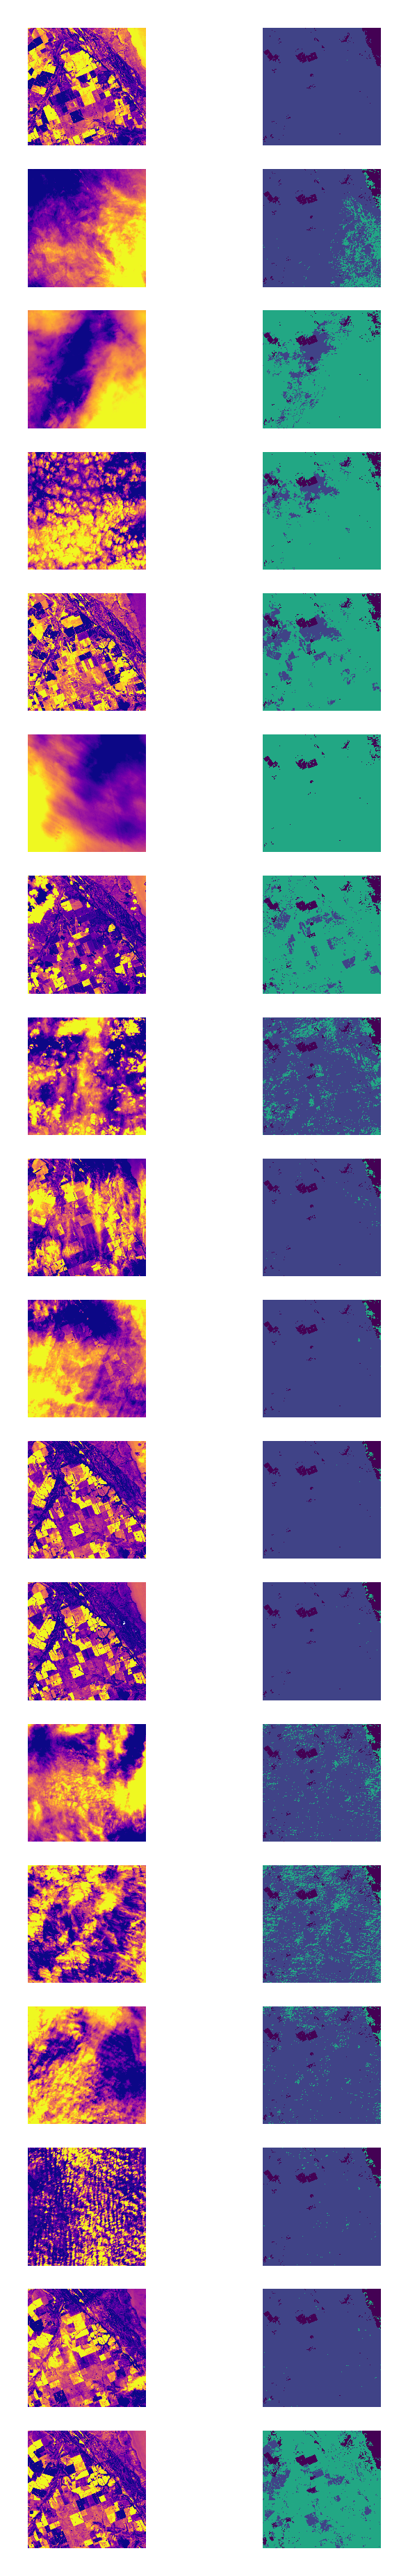

In [235]:
%matplotlib inline

fig, axes = plt.subplots(pred.shape[0], 2, dpi=400, figsize=(2, 12))

bidx = 0 # band index
cidx = 3 # class index

for pi in range(0, pred.shape[0]):

    ip = test[pi, bidx, :, :]
    ip[ip == 0] = np.nan
    
    axes[pi][0].imshow(ip, vmin=np.nanpercentile(ip, 10), vmax=np.nanpercentile(ip, 90), cmap='plasma')
    #axes[pi][1].imshow(pred[pi, cidx, :, :], vmin=0, vmax=1, cmap='plasma')
    axes[pi][1].imshow(pred[pi, :, :, :].argmax(axis=0), vmin=0, vmax=5)
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [ ]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [ ]:
# time 1
# a[:, 0, :]

In [ ]:
# time 2
# a[:, 1, :]

In [ ]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]